# Analiza c.d. oraz modelowanie
Paweł Bęza <br>
Artur Mazur

## Przygotowanie danych

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from models import build_model, compare_result

%load_ext autoreload
%autoreload 2

In [2]:
seed = 42
test_size = 0.1

In [3]:
sessions = pd.read_csv("merged_dataset", sep=' ')

### Usunięcie nieużywanych atrybutów

In [4]:
sessions = sessions.drop(['session_id', 'user_id', 'unique_categories'], axis=1)

Odrzucamy atrybut *unique_categories* ponieważ z poprzedniej analizy wynika, że każdy użytkownik i tak przegląda tylko jedną kategorie produktów

### One hot encoding

In [5]:
sessions = pd.get_dummies(sessions, columns = ['offered_discount', 'weekday'])

### Podzielnie zbioru na zbiór treningowy 90% oraz testowy 10%

In [6]:
X = sessions.drop('purchase', axis=1)
Y = sessions[['purchase']]

In [7]:
records_num = len(sessions)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [8]:
print('Size of entire dataset: ', records_num)
print('Size of training set: ', len(X_train))
print('Size of test set: ', len(X_test))

Size of entire dataset:  37863
Size of training set:  34076
Size of test set:  3787


In [9]:
X_train.head()

,price,duration,weekend,hour,unique_item_views,item_views,click_rate,last_session_purchase,offered_discount_0,offered_discount_5,offered_discount_10,offered_discount_15,offered_discount_20,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0
18085,49.99,674.0,True,22.0,8.0,8.0,0.712166,True,1,0,0,0,0,0,0,0,0,0,1,0
9469,269.00,485.0,False,9.0,3.0,4.0,0.494845,True,0,0,0,0,1,0,0,0,0,1,0,0
13834,58.97,0.0,False,11.0,1.0,1.0,0.000000,False,0,0,1,0,0,0,0,1,0,0,0,0
15242,29.99,1009.0,True,9.0,7.0,7.0,0.416254,False,1,0,0,0,0,0,0,0,0,0,1,0
33819,79.90,86.0,False,9.0,2.0,2.0,1.395349,True,0,1,0,0,0,0,1,0,0,0,0,0


## Korelacja między atrybutami

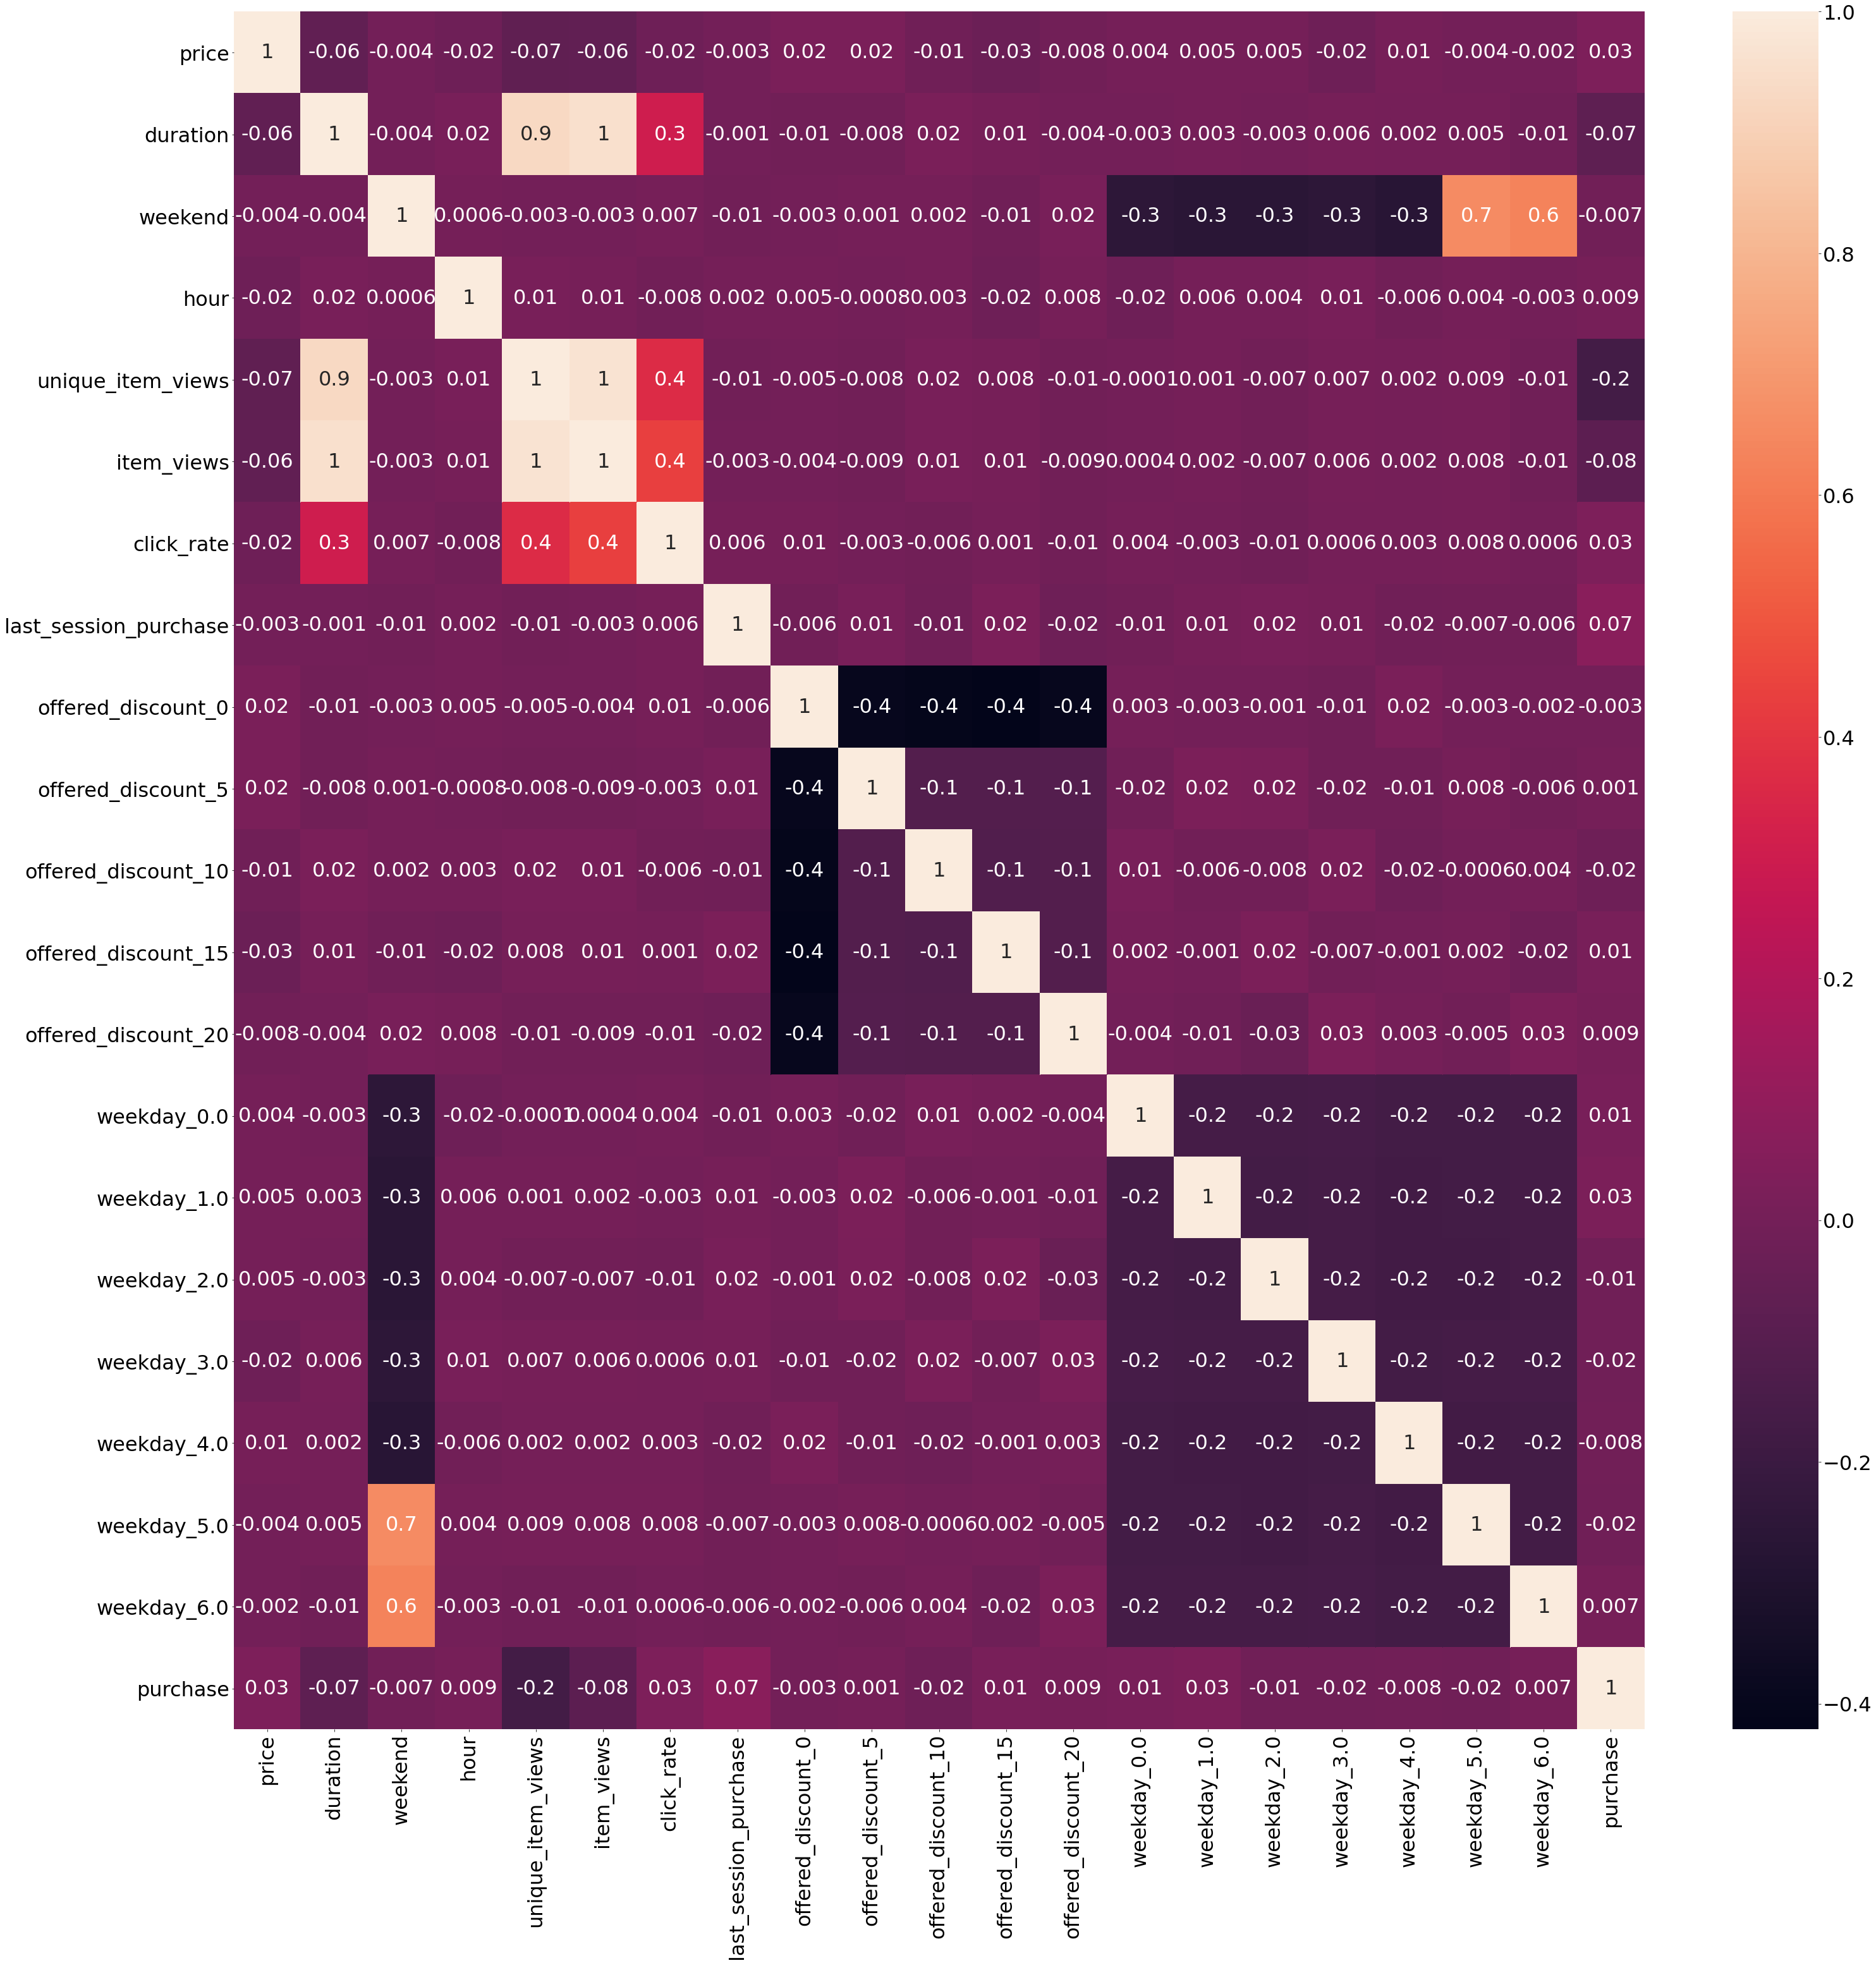

In [10]:
plt.rcParams['figure.figsize'] = [50, 50]
plt.rcParams.update({'font.size': 32})

train = pd.concat([X_train, Y_train], axis=1)

sns.heatmap(
    train.corr(method = 'spearman'),
    xticklabels = train.columns,
    yticklabels = train.columns,
    annot=True,
    fmt='0.1g'
)

Zauważamy bardzo wysoką korelacje między długością trwania sesji *duration* a liczbą wyświetlonych przedmiotów w sumie *item_views* oraz liczbą wyświetlonych unikalnych przedmiotów *unique_item_views*. Dlatego w dalszej części zrezygnujemy z części wymienionych atrybutów. Wybór będzie zależeć od wartości chi kwadrat dla poszczególnych atrybutów.

## Selekcja atrybutów Chi-kwadrat

In [11]:
list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X_train, Y_train)

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X_train.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj = dfObj.sort_values(by=[0], ascending = False)

display(dfObj)

,0,1
1,86727.888520,duration
0,2354.774938,price
4,1214.162122,unique_item_views
5,387.335018,item_views
6,141.886739,click_rate
7,86.759302,last_session_purchase
14,22.859284,weekday_1.0
3,10.513115,hour
10,8.865319,offered_discount_10
18,6.861259,weekday_5.0


Spośród atrybutów *duration*, *unique_item_views* oraz *item_views* odrzucamy atrybut *unique_item_views* oraz *item_views*, ponieważ mają mniejszą wartość statystyki chi kwadrat od *duration* i jednocześnie są z tym parametrem wysoce skorelowane co widać w macierzy korelacji powyżej.

Dodatkowo usuwamy atrybuty, dla których wartość statystki chi kwadrat jest bardzo bliska 0 tj. atrybuty *offered_discount_0* oraz *offered_discount_5*

## Wybór wejść i wyjść modelu

Zatem naszymi danymi wejściowymi modelu będą następujące atrybuty:
* *duration* - długość trwania sesji w sekundach
* *click_rate* - liczba zdarzeń(event'ów) do aktualnego rekordu na minutę
* *weekday*_0.0 - weekday_6.0 - one hot encoding dni tygodnia
* *hour* - godzina
* *offered_discount*_10, 15, 20 - one hot encoding 10, 15 oraz 20%-owej zniżki
* *weekend* -  wartość boolowska odpowiadająca na pytanie czy sesja trwa w weekend

Ponadto dodaliśmy nowe atrybuty:
* *last_session_purchase* - odpowiada na pytanie czy ostatnia sesja zakończyła się zakupem
* *price* - cena przeglądanego produktu

Natomiast zmienną celu jest prawdopoboieństwo tego, że sesja zakończy się zakupem. Model będzie zwracał, że sesja zakończy się zakupem jeśli prawdopodobieństwo zakupu będzie większe od pewnej wartości granicznej.

In [12]:
sessions = pd.read_csv("merged_dataset", sep=' ')

result_dict = {}

dropped_cols_with_corelated_attr = list(dfObj[dfObj[0] < 1][1])
dropped_cols_with_corelated_attr.extend(['session_id', 'user_id', 'unique_categories'])

dropped_cols_without_corelated_attr = dropped_cols_with_corelated_attr[:]
dropped_cols_without_corelated_attr.extend(['unique_item_views', 'item_views'])

onehot_cols = ['offered_discount', 'weekday']

## Regresja logistyczna

In [13]:
def logistic_fn_tuning(X_train, Y_train):
    # hyperparameters tuning
    model = LogisticRegression(max_iter=500)
    # define evaluation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['l2']
    space['C'] = [100, 10, 1.0, 0.1, 0.01]

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    search = RandomizedSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed)
    search.fit(X_train, Y_train)
    
    print(search.best_estimator_) # model = LogisticRegression(C=0.1, max_iter=500, solver='newton-cg')
    return search.best_estimator_

def logistic_fn(X_train, Y_train):
    model = LogisticRegression(C=0.1, max_iter=500, solver='newton-cg')
    model.fit(X_train, Y_train)
    
    return model

result_dict['Logistic Regression with corelated attributes'] = \
    build_model(logistic_fn, sessions, onehot_cols, dropped_cols_with_corelated_attr, 'purchase', 
                seed, test_size)

result_dict['Logistic Regression without corelated attributes'] = \
    build_model(logistic_fn, sessions, onehot_cols, dropped_cols_without_corelated_attr, 'purchase', seed, test_size, output = './microservice/models/logistic_reg.pkl')

## Lasy losowe

In [14]:
def random_forest_fn_tuning(X_train,Y_train):
    model = RandomForestClassifier()
    
    # define evaluation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)
    
    # define search space
    space = dict()
    space['n_estimators'] = [100, 200, 250, 300, 350, 400, 500, 800, 1200]
    space['max_depth'] = [5, 8, 10, 15, 20, 25, 30]
    space['min_samples_split'] = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
    space['min_samples_leaf'] = [1, 2, 5, 10] 
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=seed)
    search.fit(X_train, Y_train)
    
    print(search.best_estimator_) # RandomForestClassifier(max_depth=25, min_samples_split=15, n_estimators=300)
    
    return search.best_estimator_

def random_forest_fn(X_train,Y_train):
    model = RandomForestClassifier(max_depth=9, min_samples_split=15, n_estimators=300) 
    model.fit(X_train, Y_train)
    
    return model
    
result_dict['Random_Forest with corelated attributes'] = \
    build_model(random_forest_fn, sessions, onehot_cols, dropped_cols_with_corelated_attr,
                'purchase', seed)
result_dict['Random_Forest without corelated attributes'] = \
    build_model(random_forest_fn, sessions, onehot_cols, dropped_cols_without_corelated_attr, 'purchase', seed, output='./microservice/models/random_forest.pkl')

In [15]:
scope = ['training', 'test']
records = []
for name in result_dict:
    for option in scope:
        record = []
        for key in result_dict[name][option]:
            record.append(result_dict[name][option][key])
        records.append(record)
            
df = pd.DataFrame.from_records(records)
df.columns = ['Accuracy', 'Precision', 'Recall', 'F1_score']
df.index = ['LR with corelated attributes / training data', 'LR with corelated attributes / test data', 
            'LR without corelated attributes / training data', 'LR without corelated attributes / test data', 
            'RF with corelated attributes / training data', 'RF with corelated attributes / test data', 
            'RF without corelated attributes / training data', 'RF without corelated attributes / test data']
df

,Accuracy,Precision,Recall,F1_score
LR with corelated attributes / training data,0.658440,0.848773,0.357069,0.502671
LR with corelated attributes / test data,0.667019,0.865285,0.366027,0.514440
LR without corelated attributes / training data,0.555112,0.547707,0.457537,0.498578
LR without corelated attributes / test data,0.566675,0.560131,0.469589,0.510879
RF with corelated attributes / training data,0.663255,0.781392,0.422668,0.548593
RF with corelated attributes / test data,0.646771,0.749610,0.396258,0.518452
RF without corelated attributes / training data,0.639947,0.650754,0.553123,0.597980
RF without corelated attributes / test data,0.595801,0.592869,0.503302,0.544426


## Analiza wyników

Zaproponowaliśmy 2 modele tj. model bazowy będący regresją logistyczną oraz bardziej zaawansowany model docelowy będący modelem lasów losowych. Dodatkowo dla każdego z modeli rozpatrzyliśmy 2 przypadki:
- uwzględnienie skorelowanych atrybutów
- usunięcie skorelowanych atrybutów tj. usunięcie atrybutów 'unique_item_views' oraz 'item_views' i zachowanie atrybutu 'duration'

Dla każdego z powyższych modeli obliczyliśmy miarę Accuracy oraz F1-score. Pierwsza wartość opisuje liczbę trafnych przewidywań do wszystkich próbek. Natomiast F1-score jest średnią harmoniczną z recall oraz precision. <br> <br>
Zdecydowaliśmy się jednak, że naszą analityczną miarą sukcesu będzie F1-score, ponieważ nasze zadanie biznesowe polega na "klasyfikacji sesji, które zakończą się zakupem co umożliwi konsultantom szybsze rozwiązywanie problemów". Z tego można wywnioskować, że zależy nam na tym aby:
- liczba przypadków nieprawidłowo sklasyfikowanych jako sesje niekupujące była jak najmniejsza, dzięki czemu nie pomijamy sesji kupujących, które będą mogły wymagać interwencji konsultantów
- liczba przypadków sklasyfikowanych niepoprawnie jako sesja kupująca była jak najmniejsza dzięki czemu oszczędzamy czas konsultantów

Z tego wynika, że bardziej zależy nam nam na False Negative'ach oraz False Positive'ach niż na True Positive'ach oraz True Negative'ach

Analizując wyniki, możemy zauważyć że model Random Forest ma większą miarę F1 od regresji logistycznej zarówno w przypadku zachowania skorelowanych atrybutów jak i w przypadku usnięcia ich. <br>
W obu przypadkach postanowiliśmy usunąć atrybuty skorelowane tj. 'unique_item_views' oraz 'item_views' z racji na wartości F1.